In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import statsmodels.api as sm
import matplotlib
import warnings

from itertools import product
from scipy import stats
from scipy.special import inv_boxcox
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import PolynomialFeatures
from sklearn.metrics import mean_absolute_error

%matplotlib inline
matplotlib.rcParams['figure.figsize'] = [17, 6]
matplotlib.rcParams['font.size'] = 12

warnings.filterwarnings('ignore')

## Подготовка данных

Откроем датасет из прошлого урока и сделаем временной ряд стационарным.

In [2]:
df = pd.read_csv('data/BeerWineLiquor.csv', index_col=0)
df.index = pd.to_datetime(df.index, format="%m/%d/%Y")

df['boxcox'], lmbda = stats.boxcox(df.beer)
df['boxcox_shifted_S'] = df.boxcox - df.boxcox.shift(12)
df['boxcox_shifted'] = df.boxcox_shifted_S - df.boxcox_shifted_S.shift(1)

Далее разделим данные на тренировочную и тестовую выборки для того, чтобы как-то оценить качество прогноза.

In [3]:
train_size = int(df.shape[0] * 0.85)
df_train = df.iloc[:train_size]
df_test = df.iloc[train_size:]
print(f'В тестовой выборке находится {train_size} элементов. В тестовой - {df_test.shape[0]}')

В тестовой выборке находится 275 элементов. В тестовой - 49


## Прогнозирование

### Попытка № 1

Попробуем построить зависимость продажи пива от времени.

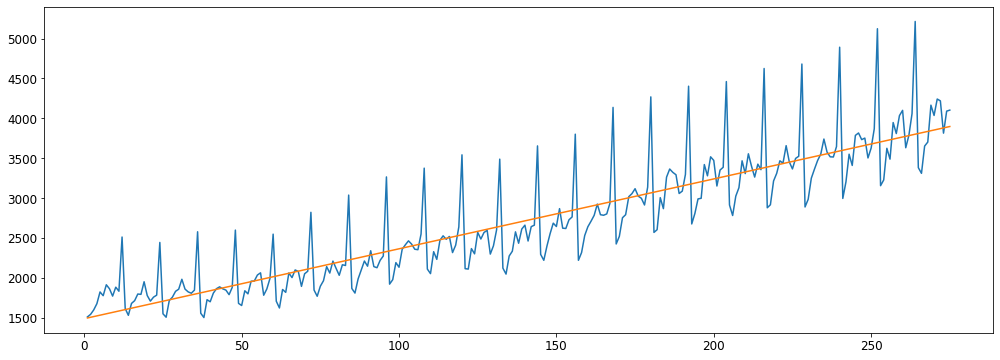

In [4]:
X_train = np.arange(1, df_train.beer.size + 1).reshape(-1, 1)
y_train = df_train.beer

lr = LinearRegression()
lr.fit(X_train, y_train)

plt.plot(X_train, y_train)
plt.plot(X_train, lr.predict(X_train))
plt.show()

Линейная регрессия показывает себя не очень хорошо. Она не способна описать даже тренировочные данные, так что смотреть на прогноз смысла не имеет.

### Попытка № 2

Попробуем построить зависимость не от времени, а от его полинома или логарифма

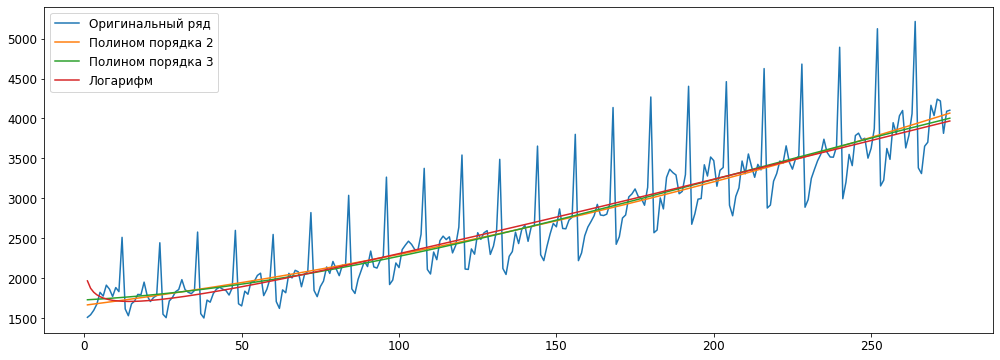

In [5]:
X1_train = PolynomialFeatures(2).fit_transform(X_train)
X2_train = PolynomialFeatures(3).fit_transform(X_train)
X3_train = np.hstack([X_train, np.log(X_train)])

lr1 = LinearRegression().fit(X1_train, y_train)
lr2 = LinearRegression().fit(X2_train, y_train)
lr3 = LinearRegression().fit(X3_train, y_train)

plt.plot(X_train, y_train)
plt.plot(X_train, lr1.predict(X1_train))
plt.plot(X_train, lr2.predict(X2_train))
plt.plot(X_train, lr3.predict(X3_train))
plt.legend([
    'Оригинальный ряд',
    'Полином порядка 2',
    'Полином порядка 3',
    'Логарифм'
])
plt.show()

Всё ещё плохо. Перейдём к авторегрессионным методам.

Как и было описано в прошлом уроке, ARMA (и AR) работают со стационарными рядами. А значит их они и предсказывают. Значит нужно эти ряды восстанавливать. Давайте создадим для этого функцию.

In [6]:
def resore_prediction(y_pred):
    y_pred += df.boxcox_shifted_S.shift(1)[train_size:]
    y_pred += df.boxcox.shift(12)[train_size:]
    y_pred = inv_boxcox(y_pred, lmbda)
    return y_pred

### Попытка № 3

Попробуем провести анализ ряда с помощью чистой авторегрессии. 

Не забываем, что наш стационарный ряд имеет в себе 13 NaN значений. От них нужно избавляться.

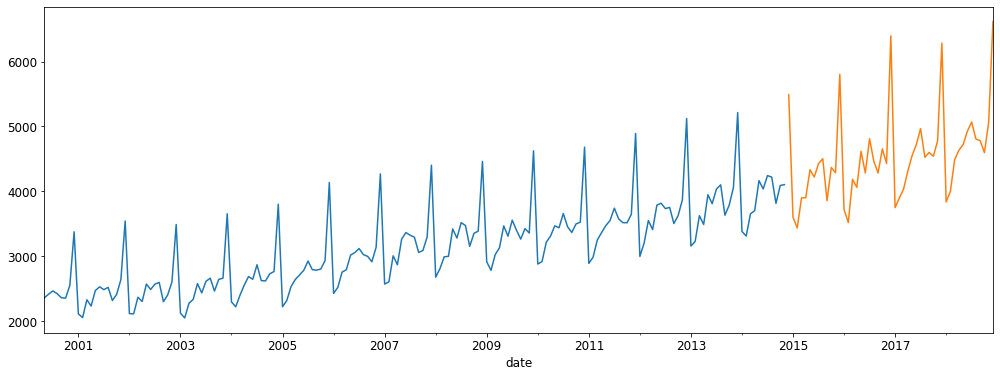

MAE = 114.37521195513024


In [7]:
model = sm.tsa.AutoReg(df_train.boxcox_shifted[13:], 2).fit()

y_pred = model.model.predict(model.params, start=df_test.index.min(), end=df_test.index.max())
y_pred = pd.Series(y_pred.values, index=df_test.index)
y_pred = resore_prediction(y_pred)

df_train.beer[100:].plot()
y_pred.plot()
plt.show()

print(f'MAE = {mean_absolute_error(df_test.beer, y_pred)}')

На графике я отсёк первые 100 значений исключительно для показательности примера. Чем меньше линий на графике - тем, проще его воспринимать.

### Скользящее среднее

Как я уже говорил, использовать скользящее среднее для прогноза временного ряда не стоит. Но если вы хотите посмотреть, как выглядит скользящее среднее на графике, то вот.

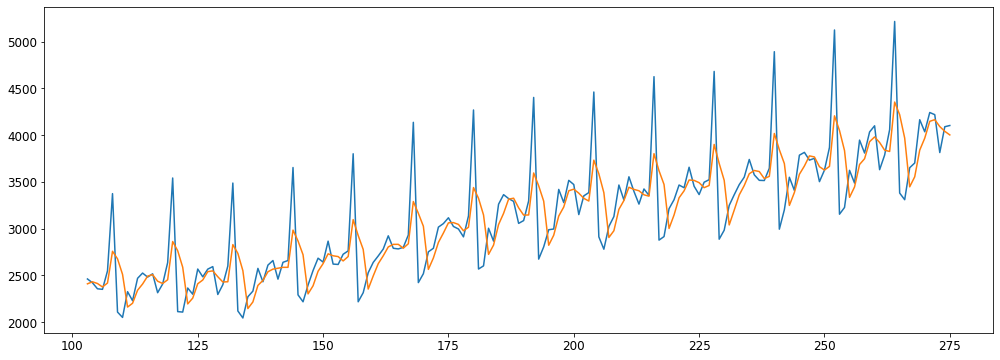

In [8]:
def MA(series, q):
    return np.convolve(series, np.ones((q,))/q, mode='valid')

plt.plot(X_train[102:], df_train.beer[102:])
plt.plot(X_train[102:], MA(df_train.beer.values, 3)[100:])
plt.show()

Тут я снова отсёк первые 100 значений для наглядности. А ещё 2 пошло на отсечение из-за работы МА. Это алгоритм создает ряд, длина которого на *q - 1* единиц меньше, чем у исходного ряда. Я задал *q = 3*, поэтому моя реализация МА создала ряд, длиной на 2 меньше.

### Попытка № 4

Ну вот он - наш босс. Наш AR и MA. Наш ARMA.

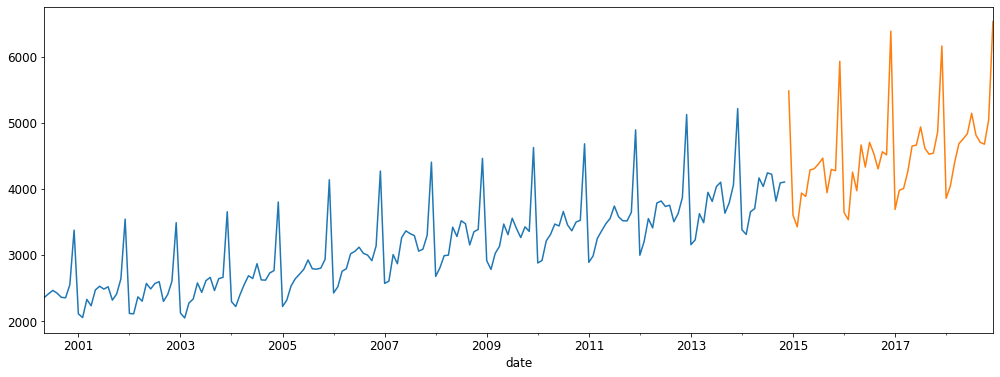

MAE = 111.00749924491913


In [9]:
model = sm.tsa.ARMA(df_train.boxcox_shifted[13:], (2, 3)).fit()

y_pred = model.model.predict(model.params, start=df_test.index.min(), end=df_test.index.max())
y_pred = pd.Series(y_pred, index=df_test.index)
y_pred = resore_prediction(y_pred)

df_train.beer[100:].plot()
y_pred.plot()
plt.show()

print(f'MAE = {mean_absolute_error(df_test.beer, y_pred)}')

Как видите, ошибка немного снизилась. Этого уже достаточно, чтобы использовать ARMA вместо AR. Но порой улучшение бывает гораздо более значимым.

Ну а пока что это всё. В следующих уроках я расскажу, почему ARMA называется семейством алгоритмов, и как можно находить параметры *p* и *q* модели ARMA(p, q).